In [1]:
# Esta celda actúa sobre la libreta, y permite que se aproveche mejor el espacio.
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:95%}</style>"))
import sys
print(sys.executable) 
#import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
from sklearn import preprocessing

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
El codigo Python de este cuaderno está oculto para facilitar la lectura.
Para mostrar/ocultar el código, haz click <a href="javascript:code_toggle()">aquí.</a>.''')

c:\users\48259328\appdata\local\programs\python\python38\python.exe


# Load results

In [2]:
import pandas as pd
df_alg=pd.read_csv('output/merged_output_genetic.txt')
convert_dict = {'Dataset': "string", 
                'Algorithm': "string",
                'Population Length': "int64",
                'Generations': "int64",
                'Selection Scheme': "string",
                'Selection Candidates': "int64",
                'Crossover Scheme': "string",
                'Crossover Probability': "float64",
                'Mutation Scheme': "string",
                'Mutation Probability': "float64",
                'Replacement Scheme': "string",
                'Time(s)': "float64",
                'AvgValue': "float64",
                'BestAvgValue': "float64",
                'BestGeneration': "int64",
                'HV': "float64",
                'Spread': "float64",
                'NumSolutions': "float64",
                'Spacing': "float64",
                'NumGenerations': "int64"
               } 
df_alg = df_alg.astype(convert_dict) 
df_alg.loc[(df_alg.Dataset == 'dataset1'),'Dataset']='1'
df_alg.loc[(df_alg.Dataset == 'dataset2'),'Dataset']='2'
display(df_alg.head(2))

df_alg2=pd.read_csv('output/merged_output_grasp.txt')
convert_dict = {'Dataset': "string", 
                'Algorithm': "string",
                'Iterations': "int64",
                'Solutions per Iteration': "int64",
                'Local Search Type': "string",
                'Time(s)': "float64",
                'AvgValue': "float64",
                'BestAvgValue': "float64",
                'HV': "float64",
                'Spread': "float64",
                'NumSolutions': "int64",
                'Spacing': "float64",
                'NumGenerations': "int64"
               } 
df_alg2 = df_alg2.astype(convert_dict)
display(df_alg2.head(2))

df_alg = df_alg.append(df_alg2)
display(df_alg.head(2))

,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,Replacement Scheme,Time(s),AvgValue,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations
0,1,NSGAIIAlgorithm,30,100,tournament,2,onepoint,0.6,flip1bit,1.0,elitism,17.442279,0.021659,0.048152,52,1.0,0.904338,29.0,0.385848,100
1,1,NSGAIIAlgorithm,30,100,tournament,2,onepoint,0.6,flip1bit,1.0,elitism,17.623707,0.023740,0.048152,57,1.0,0.905196,30.0,0.412044,100


,Dataset,Algorithm,Iterations,Solutions per Iteration,Local Search Type,Time(s),AvgValue,BestAvgValue,HV,Spread,NumSolutions,Spacing,NumGenerations
0,1,GRASP,200,60,best_first_neighbor,9.761933,0.031079,0.048152,0.230341,0.679990,54,0.301450,200
1,1,GRASP,200,60,best_first_neighbor,9.858529,0.030975,0.048152,0.230341,0.680027,58,0.299203,200


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
0,1,NSGAIIAlgorithm,30.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,1.0,...,0.048152,52.0,1.0,0.904338,29.0,0.385848,100,NaN,NaN,<NA>
1,1,NSGAIIAlgorithm,30.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,1.0,...,0.048152,57.0,1.0,0.905196,30.0,0.412044,100,NaN,NaN,<NA>


---
# Helper functions

## Find configurations in a dataframe

In [3]:
def findConfigurationDataGenetic(df,algorithm):
    return df[(df["Population Length"]==algorithm.p)&(df["Generations"]==algorithm.g)
                     &(df["Selection Scheme"]==algorithm.ss)&(df["Selection Candidates"]==algorithm.sc)
                     &(df["Crossover Scheme"]==algorithm.cs)&(df["Crossover Probability"]==algorithm.cp)
                     &(df["Mutation Scheme"]==algorithm.ms)&(df["Mutation Probability"]==algorithm.mp)
              &(df["Algorithm"]==algorithm.a)&(df["Replacement Scheme"]==algorithm.rs)
              &(df["Dataset"]==algorithm.d)
             ]
def findConfigurationDataGrasp(df,algorithm):
    return df[(df["Iterations"]==algorithm.it)&(df["Solutions per Iteration"]==algorithm.so)
              &(df["Local Search Type"]==algorithm.ls)
              &(df["Algorithm"]==algorithm.a)&(df["Dataset"]==algorithm.d)
             ]

## Algorithm config structure

In [4]:
from sklearn import preprocessing
import plotly.graph_objects as go
import plotly.offline as pyo
import math
class AlgorithmDataGenetic():
    def __init__(self,a,rs,d,p,g,ss,sc,cs,cp,ms,mp):
        self.a=a
        self.rs=rs
        self.d=d
        self.p=p
        self.g=g
        self.ss=ss
        self.sc=sc
        self.cs=cs
        self.cp=cp
        self.ms=ms
        self.mp=mp
    
    def findConfigurationData(self,df):
        return df[(df["Population Length"]==self.p)&(df["Generations"]==self.g)
                     &(df["Selection Scheme"]==self.ss)&(df["Selection Candidates"]==self.sc)
                     &(df["Crossover Scheme"]==self.cs)&(df["Crossover Probability"]==self.cp)
                     &(df["Mutation Scheme"]==self.ms)&(df["Mutation Probability"]==self.mp)
              &(df["Algorithm"]==self.a)&(df["Replacement Scheme"]==self.rs)
              &(df["Dataset"]==self.d)
             ]
        
class AlgorithmDataGrasp():
    def __init__(self,a,d,it,so,ls):
        self.a=a
        self.it=it
        self.so=so
        self.ls=ls
        self.d=d
        
    def findConfigurationData(self,df):
        return df[(df["Iterations"]==self.it)&(df["Solutions per Iteration"]==self.so)
              &(df["Local Search Type"]==self.ls)
              &(df["Algorithm"]==self.a)&(df["Dataset"]==self.d)
             ]

## Calculate star chart given an array of configurations and a dataset

In [5]:
import seaborn as sns

def calculateStarChart(algorithms_array,dataset,time_limit,title,onlyResult=False,fileName="fig1.svg",legend=True):
    #algorithm, replacement,dataset,p,g,ss,sc,cs,cp,ms,mp
    df_radar = df_alg.copy(deep=True)
    df_chartdata=pd.DataFrame(columns=df_radar.columns)
    for algorithm in algorithms_array:
        df_star_d1_gnds=algorithm.findConfigurationData(df_radar)
        print("Datos configuracion") if not onlyResult else 0
        display(df_star_d1_gnds.head(5)) if not onlyResult else 0
        df_chartdata=df_chartdata.append(df_star_d1_gnds)
        
    display(df_chartdata.head(5)) if not onlyResult else 0
    
    scaler = preprocessing.MinMaxScaler()
    
    df_radar=df_radar[(df_radar['Dataset']==dataset)&(df_radar['Time(s)']<time_limit)]
                
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=df_radar["Time(s)"])
    
    df_radar['Time(s)']=1/df_radar['Time(s)']
    df_radar['Spread']=1/df_radar['Spread']
    
    df_radar['HV'] = scaler.fit_transform(df_radar[['HV']].values.astype(float))
    df_radar['Spread'] = scaler.fit_transform(df_radar[['Spread']].values.astype(float))
    df_radar['Spacing'] = scaler.fit_transform(df_radar[['Spacing']].values.astype(float))
    df_radar['NumSolutions'] = scaler.fit_transform(df_radar[['NumSolutions']].values.astype(float))
    df_radar['AvgValue'] = scaler.fit_transform(df_radar[['AvgValue']].values.astype(float))
    df_radar['Time(s)'] = scaler.fit_transform(df_radar[['Time(s)']].values.astype(float))
    
    print("Datos normalizados") if not onlyResult else 0
    display(df_radar[df_radar["Algorithm"]=="GRASP"]) if not onlyResult else 0

    
    # dibujar grafico
    categories = ['AvgValue', 'NºSols', 'Spacing', '1/Spread','HV']
    categories = [*categories, categories[0]]

    data=[]
    titles=[]
    for algorithm in algorithms_array:
        df_aux=algorithm.findConfigurationData(df_radar)
        display(df_aux)
        df_aux_means=df_aux[['AvgValue','Spread', 'Spacing', 'NumSolutions','HV',]].mean()
        print("means") if not onlyResult else 0
        display(df_aux_means) if not onlyResult else 0
        aux_data = list(df_aux_means) 
        aux_data = [*aux_data, aux_data[0]]
        data.append(aux_data)
        titles.append( (algorithm.a#+"-"+algorithm.rs
                       ) )
        print(aux_data)
    markers=["circle","square","diamond", "square"]
    dashes=["solid","dot","dash","solid"]
    titles=["GeneticNDS elitism","GeneticNDS elitismNDS","NSGA-II","GRASP"]
    fig = go.Figure(
        data=[
            go.Scatterpolar(r=data[x],marker_symbol=markers[x] ,theta=categories, name=titles[x],line_dash=dashes[x]) for x in range(0,len(data))
        ],
        layout=go.Layout(
            polar={'radialaxis': {'visible': True,'showticklabels':False,'range':[0, 1],'showline':False},
                   'angularaxis':{'rotation':90,},
                  },
            showlegend=legend
        )
    )
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="center",
        x=0.5
    ))
    pyo.plot(fig)
    fig.write_image(fileName)

AvgValue         0.031765
Spread           0.660974
Spacing          0.316906
NumSolutions    42.000000
HV               0.230341
dtype: float64

Datos configuracion


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
1150,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028555,44.0,0.535208,0.714937,21.0,0.262689,100,NaN,NaN,<NA>
1151,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028555,71.0,0.565417,0.622035,24.0,0.273270,100,NaN,NaN,<NA>
1152,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,25.0,0.687504,0.490052,25.0,0.287407,100,NaN,NaN,<NA>
1153,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,76.0,0.687504,0.523024,29.0,0.282334,100,NaN,NaN,<NA>
1154,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,61.0,0.687504,0.590299,28.0,0.288339,100,NaN,NaN,<NA>


Datos configuracion


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
18920,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028555,44.0,0.535208,0.460294,21.0,0.262689,100,NaN,NaN,<NA>
18921,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028485,65.0,0.565417,0.607517,24.0,0.260655,100,NaN,NaN,<NA>
18922,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,25.0,0.687504,0.677789,24.0,0.271149,100,NaN,NaN,<NA>
18923,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.029435,8.0,0.687504,0.600878,28.0,0.271737,100,NaN,NaN,<NA>
18924,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.029435,1.0,0.687504,0.611231,27.0,0.277986,100,NaN,NaN,<NA>


Datos configuracion


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
11730,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028555,44.0,0.554746,0.860128,18.0,0.280597,100,NaN,NaN,<NA>
11731,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028275,70.0,0.625413,0.874007,16.0,0.344572,100,NaN,NaN,<NA>
11732,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.040500,72.0,0.412502,0.876175,16.0,0.279391,100,NaN,NaN,<NA>
11733,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.029003,69.0,0.445755,0.876580,15.0,0.251337,100,NaN,NaN,<NA>
11734,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.024156,58.0,0.543640,0.867738,19.0,0.295910,100,NaN,NaN,<NA>


Datos configuracion


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
480,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.672148,35.0,0.340702,20,20.0,20.0,best_first_neighbor
481,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.637583,39.0,0.327439,20,20.0,20.0,best_first_neighbor
482,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.637583,39.0,0.327439,20,20.0,20.0,best_first_neighbor
483,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.639563,41.0,0.314822,20,20.0,20.0,best_first_neighbor
484,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.658993,43.0,0.302797,20,20.0,20.0,best_first_neighbor


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
1150,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028555,44.0,0.535208,0.714937,21.0,0.262689,100,NaN,NaN,<NA>
1151,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028555,71.0,0.565417,0.622035,24.0,0.273270,100,NaN,NaN,<NA>
1152,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,25.0,0.687504,0.490052,25.0,0.287407,100,NaN,NaN,<NA>
1153,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,76.0,0.687504,0.523024,29.0,0.282334,100,NaN,NaN,<NA>
1154,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,61.0,0.687504,0.590299,28.0,0.288339,100,NaN,NaN,<NA>


Datos normalizados


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
0,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.278026,0.877551,0.347321,200,200.0,60.0,best_first_neighbor
1,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.277971,0.959184,0.342834,200,200.0,60.0,best_first_neighbor
2,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.286133,0.979592,0.341915,200,200.0,60.0,best_first_neighbor
3,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.286133,0.979592,0.341915,200,200.0,60.0,best_first_neighbor
4,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.279692,1.000000,0.334540,200,200.0,60.0,best_first_neighbor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.279692,1.000000,0.334540,300,300.0,100.0,best_first_neighbor
496,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.279692,1.000000,0.334540,300,300.0,100.0,best_first_neighbor
497,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.279692,1.000000,0.334540,300,300.0,100.0,best_first_neighbor
498,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.279692,1.000000,0.334540,300,300.0,100.0,best_first_neighbor


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
1150,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028555,44.0,0.405560,0.228702,0.204082,0.269935,100,NaN,NaN,<NA>
1151,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028555,71.0,0.444195,0.372039,0.265306,0.291060,100,NaN,NaN,<NA>
1152,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,25.0,0.600337,0.669120,0.285714,0.319284,100,NaN,NaN,<NA>
1153,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,76.0,0.600337,0.580852,0.367347,0.309156,100,NaN,NaN,<NA>
1154,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,61.0,0.600337,0.431342,0.346939,0.321144,100,NaN,NaN,<NA>
1155,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,80.0,0.600337,0.713135,0.285714,0.337033,101,NaN,NaN,<NA>
1156,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,6.0,0.592098,0.496872,0.244898,0.364249,100,NaN,NaN,<NA>
1157,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,76.0,0.592098,0.520932,0.306122,0.373109,100,NaN,NaN,<NA>
1158,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,69.0,0.592098,0.520932,0.306122,0.373109,100,NaN,NaN,<NA>
1159,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,61.0,0.592098,0.528741,0.326531,0.356599,100,NaN,NaN,<NA>


means


AvgValue        0.376970
Spread          0.506267
Spacing         0.331468
NumSolutions    0.293878
HV              0.561949
dtype: float64

[0.37697029960554174, 0.5062668595423371, 0.33146777148800827, 0.2938775510204082, 0.561949452401011, 0.37697029960554174]


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
18920,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028555,44.0,0.405560,0.759637,0.204082,0.269935,100,NaN,NaN,<NA>
18921,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028485,65.0,0.444195,0.398399,0.265306,0.265874,100,NaN,NaN,<NA>
18922,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.032475,25.0,0.600337,0.281302,0.265306,0.286824,100,NaN,NaN,<NA>
18923,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.029435,8.0,0.600337,0.410878,0.346939,0.287999,100,NaN,NaN,<NA>
18924,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.029435,1.0,0.600337,0.391537,0.326531,0.300476,100,NaN,NaN,<NA>
18925,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028275,6.0,0.600337,0.409149,0.244898,0.303565,100,NaN,NaN,<NA>
18926,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.030235,12.0,0.600337,0.352432,0.244898,0.269619,100,NaN,NaN,<NA>
18927,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.030235,7.0,0.630025,0.253915,0.326531,0.353066,100,NaN,NaN,<NA>
18928,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.029787,2.0,0.630025,0.382171,0.285714,0.336460,100,NaN,NaN,<NA>
18929,1,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.031195,29.0,0.630025,0.549846,0.346939,0.373793,100,NaN,NaN,<NA>


means


AvgValue        0.321879
Spread          0.418927
Spacing         0.304761
NumSolutions    0.285714
HV              0.574152
dtype: float64

[0.32187876531531484, 0.4189266490418258, 0.3047609633658806, 0.2857142857142857, 0.5741516427969673, 0.32187876531531484]


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
11730,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028555,44.0,0.430548,0.066700,0.142857,0.305688,100,NaN,NaN,<NA>
11731,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028275,70.0,0.520927,0.054033,0.102041,0.433413,100,NaN,NaN,<NA>
11732,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.040500,72.0,0.248627,0.052090,0.102041,0.303281,100,NaN,NaN,<NA>
11733,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.029003,69.0,0.291154,0.051728,0.081633,0.247272,100,NaN,NaN,<NA>
11734,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.024156,58.0,0.416344,0.059704,0.163265,0.336259,100,NaN,NaN,<NA>
11735,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.028742,15.0,0.439781,0.063318,0.122449,0.417983,100,NaN,NaN,<NA>
11736,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.027600,76.0,0.219798,0.059544,0.102041,0.305570,100,NaN,NaN,<NA>
11737,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.024760,78.0,0.352974,0.056597,0.122449,0.317379,100,NaN,NaN,<NA>
11738,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.034714,47.0,0.290463,0.049462,0.061224,0.316236,100,NaN,NaN,<NA>
11739,1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.9,flip1bit,0.05,...,0.025247,60.0,0.582628,0.071190,0.163265,0.364160,100,NaN,NaN,<NA>


means


AvgValue        0.281893
Spread          0.058437
Spacing         0.334724
NumSolutions    0.116327
HV              0.379324
dtype: float64

[0.2818928792531822, 0.058436514761340916, 0.3347240131564859, 0.11632653061224492, 0.37932434709351315, 0.2818928792531822]


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
480,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.289799,0.489796,0.425686,20,20.0,20.0,best_first_neighbor
481,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.345139,0.571429,0.399207,20,20.0,20.0,best_first_neighbor
482,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.345139,0.571429,0.399207,20,20.0,20.0,best_first_neighbor
483,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.341808,0.612245,0.374018,20,20.0,20.0,best_first_neighbor
484,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.310176,0.653061,0.350009,20,20.0,20.0,best_first_neighbor
485,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.276948,0.653061,0.370434,20,20.0,20.0,best_first_neighbor
486,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.282146,0.673469,0.373213,20,20.0,20.0,best_first_neighbor
487,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.289507,0.693878,0.363033,20,20.0,20.0,best_first_neighbor
488,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.289507,0.693878,0.363033,20,20.0,20.0,best_first_neighbor
489,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.306636,0.714286,0.363932,20,20.0,20.0,best_first_neighbor


means


AvgValue        0.969933
Spread          0.307680
Spacing         0.378177
NumSolutions    0.632653
HV              0.015653
dtype: float64

[0.9699334402018316, 0.30768047258668907, 0.3781772322834639, 0.6326530612244897, 0.015652906486941842, 0.9699334402018316]


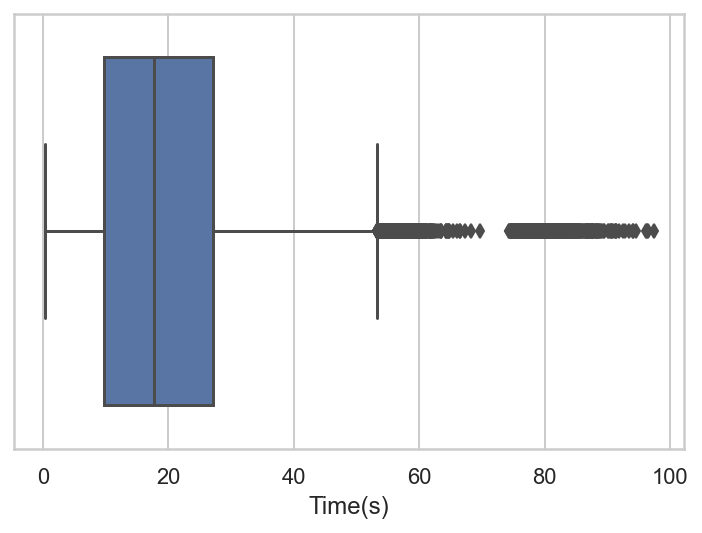

In [6]:
#prueba
algorithm1=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitism',"1",20,100,"tournament",2,"onepoint",0.9,"flip1bit",0.05)
algorithm2=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitismnds',"1",20,100,"tournament",2,"onepoint",0.9,"flip1bit",0.05)
algorithm3=AlgorithmDataGenetic("NSGAIIAlgorithm",'elitism',"1",20,100,"tournament",2,"onepoint",0.9,"flip1bit",0.05)
algorithm4=AlgorithmDataGrasp("GRASP","1",20,20,"best_first_neighbor")
df_radar = df_alg.copy(deep=True)
df_radar2 = df_alg2.copy(deep=True)
df_radar = df_radar.append(df_radar2)
display(algorithm4.findConfigurationData(df_radar)[['AvgValue','Spread', 'Spacing', 'NumSolutions','HV',]].mean())
calculateStarChart([algorithm1,algorithm2,algorithm3,algorithm4],"1",120,"title",onlyResult=False)

---
# Best configs for Dataset 1

## Best config for GeneticNDS elitism

In [7]:
algs=[]
dfs=[]
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="1")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitism',"1",40,200,"tournament",2,"onepoint",0.85,"flip1bit",0.1)
algs.append(alg)
display(alg.findConfigurationData(df_alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
468,GeneticNDSAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.80,flip1bit,1.0,28.013055,0.658138,0.597928,0.024224,0.043188,168.9,31.9,0.349022
495,GeneticNDSAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.90,flip1bit,0.7,27.981044,0.730613,0.678954,0.023188,0.040635,138.9,35.4,0.330123
313,GeneticNDSAlgorithm,30.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,0.7,26.385925,0.741607,0.604251,0.023188,0.046515,164.3,34.9,0.322782
268,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.90,flip1bit,0.1,14.973942,0.670172,0.582440,0.023100,0.046622,116.1,28.4,0.311245
439,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.90,flip1bit,0.7,19.211675,0.723467,0.616002,0.022964,0.044656,96.1,33.0,0.345722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,GeneticNDSAlgorithm,30.0,100.0,tournament,2.0,onepoint,0.60,flipeachbit,0.5,7.141742,0.585653,0.667170,0.019233,0.031615,40.0,29.0,0.249970
182,GeneticNDSAlgorithm,30.0,100.0,tournament,2.0,onepoint,0.80,flip1bit,0.0,8.194207,0.654887,0.600417,0.019174,0.028767,40.8,33.7,0.287844
7,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.60,flipeachbit,0.0,5.495701,0.605934,0.621713,0.019099,0.028816,38.9,26.3,0.274951
181,GeneticNDSAlgorithm,30.0,100.0,tournament,2.0,onepoint,0.60,flipeachbit,1.0,5.997107,0.632090,0.613577,0.018999,0.025710,29.8,26.2,0.288700


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
23730,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.028505,179.0,0.561781,0.678597,27.0,0.308810,200,NaN,NaN,<NA>
23731,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.028618,70.0,0.588578,0.680521,34.0,0.289071,200,NaN,NaN,<NA>
23732,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.038914,114.0,0.505869,0.661298,32.0,0.265675,200,NaN,NaN,<NA>
23733,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.038914,19.0,0.631381,0.660944,33.0,0.288183,200,NaN,NaN,<NA>
23734,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.038914,125.0,0.631381,0.635670,29.0,0.292839,200,NaN,NaN,<NA>
23735,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.038914,191.0,0.631381,0.626057,30.0,0.292358,212,NaN,NaN,<NA>
23736,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.038914,67.0,0.698202,0.636355,32.0,0.325388,200,NaN,NaN,<NA>
23737,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.048152,80.0,0.621408,0.585636,31.0,0.323183,200,NaN,NaN,<NA>
23738,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.048152,192.0,0.621408,0.619513,31.0,0.323183,213,NaN,NaN,<NA>
23739,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.048152,47.0,0.656610,0.634151,33.0,0.321161,200,NaN,NaN,<NA>


## Best config for GeneticNDS elitismNDS

In [8]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="1")&(df_alg["Replacement Scheme"]=="elitismnds")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitismnds',"1",30,200,"tournament",2,"onepoint",0.9,"flip1bit",0.1)
algs.append(alg)
display(alg.findConfigurationData(df_alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
169,GeneticNDSAlgorithm,30.0,100.0,tournament,2.0,onepoint,0.60,flip1bit,0.05,5.541494,0.569836,0.613420,0.023065,0.034391,33.9,20.2,0.307862
449,GeneticNDSAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.60,flip1bit,0.05,27.186015,0.691530,0.599031,0.022051,0.040737,113.3,33.1,0.308614
427,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flipeachbit,0.00,21.149818,0.716868,0.604206,0.022028,0.031195,11.8,35.2,0.327368
393,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.60,flip1bit,0.05,17.232236,0.638265,0.609055,0.021999,0.036128,96.5,30.9,0.295080
329,GeneticNDSAlgorithm,30.0,300.0,tournament,2.0,onepoint,0.90,flipeachbit,0.00,21.448062,0.667465,0.594309,0.021913,0.033637,51.8,26.7,0.314508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.60,flipeachbit,0.70,8.523356,0.529309,0.685816,0.015223,0.018908,70.0,18.7,0.215752
11,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.60,flipeachbit,0.50,4.224080,0.493203,0.650649,0.015112,0.018104,30.9,18.7,0.233160
124,GeneticNDSAlgorithm,20.0,300.0,tournament,2.0,onepoint,0.60,flipeachbit,0.70,13.187746,0.625267,0.644564,0.015067,0.019334,136.5,20.1,0.228815
12,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.60,flipeachbit,0.70,4.775326,0.583250,0.717989,0.014965,0.019670,47.9,19.2,0.247707


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
28630,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.040500,188.0,0.532257,0.642016,19.0,0.267204,209,NaN,NaN,<NA>
28631,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.033755,6.0,0.586984,0.613336,24.0,0.279895,200,NaN,NaN,<NA>
28632,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.027600,2.0,0.551426,0.555294,26.0,0.275115,200,NaN,NaN,<NA>
28633,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.027600,107.0,0.522759,0.608476,28.0,0.271306,200,NaN,NaN,<NA>
28634,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.027600,54.0,0.729438,0.651588,27.0,0.294778,200,NaN,NaN,<NA>
28635,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.027324,58.0,0.729438,0.587706,30.0,0.294654,200,NaN,NaN,<NA>
28636,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.044046,138.0,0.731177,0.610240,29.0,0.265279,200,NaN,NaN,<NA>
28637,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.028929,4.0,0.666834,0.632206,30.0,0.276510,200,NaN,NaN,<NA>
28638,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.027324,119.0,0.653830,0.565281,28.0,0.270065,200,NaN,NaN,<NA>
28639,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.032780,152.0,0.640735,0.569732,28.0,0.265139,200,NaN,NaN,<NA>


## Best config for NSGA-II elitism

In [9]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="NSGAIIAlgorithm")&(df_alg["Dataset"]=="1")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmDataGenetic("NSGAIIAlgorithm",'elitism',"1",40,300,"tournament",2,"onepoint",0.85,"flip1bit",1)
algs.append(alg)
display(alg.findConfigurationData(df_alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
482,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,80.418354,0.983925,0.929038,0.024670,0.048152,133.5,33.8,0.432767
454,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.60,flip1bit,1.0,81.424673,1.000000,0.929506,0.024645,0.048152,61.0,32.8,0.450985
468,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.80,flip1bit,1.0,80.443772,1.000000,0.929164,0.024578,0.048152,104.7,33.2,0.444865
411,NSGAIIAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.80,flip1bit,0.7,54.097351,0.968735,0.930110,0.024577,0.047667,124.0,30.8,0.430122
457,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.60,flipeachbit,0.1,79.984246,0.975887,0.929579,0.024566,0.047742,125.3,31.4,0.434639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.80,flip1bit,0.0,9.229992,0.497222,0.873502,0.017985,0.025298,52.7,15.8,0.291217
13,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.60,flipeachbit,1.0,9.821624,0.563614,0.867436,0.017822,0.028004,33.9,17.7,0.312857
41,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.85,flipeachbit,1.0,9.770178,0.544756,0.861243,0.017783,0.026955,46.8,19.5,0.283815
0,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.60,flip1bit,0.0,9.524052,0.472633,0.872152,0.017710,0.025513,57.4,13.5,0.282274


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
22030,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,75.0,1.000000,0.928791,35.0,0.449498,300,NaN,NaN,<NA>
22031,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,64.0,0.919623,0.930431,32.0,0.408847,300,NaN,NaN,<NA>
22032,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,195.0,1.000000,0.929125,32.0,0.444733,300,NaN,NaN,<NA>
22033,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,211.0,1.000000,0.929243,33.0,0.423136,300,NaN,NaN,<NA>
22034,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,154.0,0.919623,0.930104,33.0,0.387997,300,NaN,NaN,<NA>
22035,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,103.0,1.000000,0.926453,35.0,0.415061,300,NaN,NaN,<NA>
22036,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,164.0,1.000000,0.929731,34.0,0.450020,300,NaN,NaN,<NA>
22037,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,135.0,1.000000,0.929367,35.0,0.457241,300,NaN,NaN,<NA>
22038,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,110.0,1.000000,0.928964,36.0,0.448838,300,NaN,NaN,<NA>
22039,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,124.0,1.000000,0.928171,33.0,0.442300,300,NaN,NaN,<NA>


## Best config for GRASP

In [10]:
configs=["Algorithm","Iterations","Solutions per Iteration"]

df_a = df_alg[(df_alg["Algorithm"]=="GRASP")&(df_alg["Dataset"]=="1")&(df_alg["Local Search Type"]=="best_first_neighbor")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","NumSolutions","Spacing","NumGenerations"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmDataGrasp("GRASP","1",20,20,"best_first_neighbor")
algs.append(alg)
display(alg.findConfigurationData(df_alg))

,Algorithm,Iterations,Solutions per Iteration,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_numsolutions,mean_spacing
0,GRASP,20.0,20.0,0.333348,0.230341,0.660974,0.031765,0.048152,42.0,0.316906
1,GRASP,20.0,40.0,0.683472,0.230341,0.667707,0.031479,0.048152,46.6,0.309388
5,GRASP,50.0,20.0,0.831222,0.230341,0.670266,0.031380,0.048152,48.1,0.307199
2,GRASP,20.0,60.0,1.035328,0.230341,0.673354,0.031310,0.048152,49.0,0.306094
3,GRASP,20.0,80.0,1.340430,0.230341,0.674129,0.031261,0.048152,50.8,0.303524
4,GRASP,20.0,100.0,1.639607,0.230341,0.678785,0.031225,0.048152,52.3,0.302673
6,GRASP,50.0,40.0,1.672732,0.230341,0.678785,0.031225,0.048152,52.3,0.302673
10,GRASP,100.0,20.0,1.669113,0.230341,0.678785,0.031225,0.048152,52.3,0.302673
7,GRASP,50.0,60.0,2.488506,0.230341,0.680118,0.031166,0.048152,54.6,0.302275
15,GRASP,200.0,20.0,3.379686,0.230341,0.677240,0.031113,0.048152,56.0,0.300712


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
480,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.672148,35.0,0.340702,20,20.0,20.0,best_first_neighbor
481,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.637583,39.0,0.327439,20,20.0,20.0,best_first_neighbor
482,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.637583,39.0,0.327439,20,20.0,20.0,best_first_neighbor
483,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.639563,41.0,0.314822,20,20.0,20.0,best_first_neighbor
484,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.658993,43.0,0.302797,20,20.0,20.0,best_first_neighbor
485,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.680718,43.0,0.313027,20,20.0,20.0,best_first_neighbor
486,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.677225,44.0,0.314419,20,20.0,20.0,best_first_neighbor
487,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.672340,45.0,0.309320,20,20.0,20.0,best_first_neighbor
488,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.672340,45.0,0.309320,20,20.0,20.0,best_first_neighbor
489,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.230341,0.661242,46.0,0.309770,20,20.0,20.0,best_first_neighbor


## Wilcoxon Test

In [12]:
from scipy.stats import ranksums

cols=["AvgValue","HV","Spread","Spacing","NumSolutions","BestGeneration"]

results=list()
best_avg=0
best_alg_index=None
#results.append("Métrica AvgValue")
for i in range(len(algs)):
    avg=np.mean((algs[i].findConfigurationData(df_alg)[cols])["AvgValue"].values)
    results.append("{:.3f}".format(avg))
    if avg>best_avg:
        best_avg=avg
        best_alg_index=i

p_best=True
for i in range(len(algs)):
    if i!=best_alg_index:
        dataA=(algs[best_alg_index].findConfigurationData(df_alg)[cols])["AvgValue"].values
        dataB=(algs[i].findConfigurationData(df_alg)[cols])["AvgValue"].values
        _, p = ranksums(dataA, dataB)
        print(p)
        if p>=0.05:
            p_best=False
        
if p_best:
    mark = '*'
else:
    mark = ''
results[best_alg_index]=results[best_alg_index]+mark
results.insert(0,"AvgValue")
print(results)
    

0.00015705228423075119
0.00015705228423075119
0.00015705228423075119
['AvgValue', '0.022', '0.020', '0.025', '0.032*']


In [13]:
cols=["AvgValue","HV","Spread","Spacing","NumSolutions","BestGeneration","Time(s)"]
maxmin=[1,1,-1,1,1,1,-1]

for j in range(len(cols)): 
    print(cols[j])
    results=list()
    best_avg=0
    best_avgn=10**9
    best_alg_index=None
    for i in range(len(algs)):
        avg=np.mean((algs[i].findConfigurationData(df_alg)[cols])[cols[j]].values)
        results.append("{:.3f}".format(avg))
        if maxmin[j]>0 and avg>best_avg:
            best_avg=avg
            best_alg_index=i
        elif maxmin[j]<0 and avg<best_avgn:
            best_avgn=avg
            best_alg_index=i

    p_best=True
    p_list=[]
    for i in range(len(algs)):
        if i!=best_alg_index:
            dataA=(algs[best_alg_index].findConfigurationData(df_alg)[cols])[cols[j]].values
            dataB=(algs[i].findConfigurationData(df_alg)[cols])[cols[j]].values
            _, p = ranksums(dataA, dataB)
            print("p:",p)
            if p>=0.05:
                #print(dataA)
                #print(dataB)
                p_best=False
            else:
                p_list.append(i)

    if p_best:
        mark = '*'
    else:
        mark = ''
    for index in p_list:
        results[index]=results[index]+'-'
    #results[best_alg_index]=results[best_alg_index]+mark
    results.insert(0,cols[j])
    print(results)
    

AvgValue
p: 0.00015705228423075119
p: 0.00015705228423075119
p: 0.00015705228423075119
['AvgValue', '0.022-', '0.020-', '0.025-', '0.032']
HV
p: 0.00015705228423075119
p: 0.00015705228423075119
p: 0.00015705228423075119
['HV', '0.615-', '0.634-', '0.984', '0.230-']
Spread
p: 0.019109922206844435
p: 0.00015705228423075119
p: 0.000880743190741727
['Spread', '0.642-', '0.604', '0.929-', '0.661-']
Spacing
p: 0.00015705228423075119
p: 0.00015705228423075119
p: 0.00015705228423075119
['Spacing', '0.303-', '0.276-', '0.433', '0.317-']
NumSolutions
p: 0.00015705228423075119
p: 0.00015705228423075119
p: 0.00032983852077799353
['NumSolutions', '31.200-', '26.900-', '33.800-', '42.000']
BestGeneration
p: 0.3257513544787166
p: 0.08209870865427452
p: 0.00015705228423075119
['BestGeneration', '108.400', '82.800', '133.500', 'nan-']
Time(s)
p: 0.00015705228423075119
p: 0.00015705228423075119
p: 0.00015705228423075119
['Time(s)', '18.046-', '14.528-', '80.418-', '0.333']


## Generate Star Chart

,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
23730,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.028505,179.0,0.439545,0.280097,0.326531,0.362014,200,NaN,NaN,<NA>
23731,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.028618,70.0,0.473816,0.277239,0.469388,0.322607,200,NaN,NaN,<NA>
23732,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.038914,114.0,0.368037,0.306547,0.428571,0.275897,200,NaN,NaN,<NA>
23733,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.038914,19.0,0.528559,0.307104,0.448980,0.320833,200,NaN,NaN,<NA>
23734,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.038914,125.0,0.528559,0.348379,0.367347,0.330129,200,NaN,NaN,<NA>
23735,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.038914,191.0,0.528559,0.364952,0.387755,0.329169,212,NaN,NaN,<NA>
23736,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.038914,67.0,0.614019,0.347217,0.428571,0.395112,200,NaN,NaN,<NA>
23737,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.048152,80.0,0.515805,0.440596,0.408163,0.390710,200,NaN,NaN,<NA>
23738,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.048152,192.0,0.515805,0.376530,0.408163,0.390710,213,NaN,NaN,<NA>
23739,1,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.1,...,0.048152,47.0,0.560826,0.350963,0.448980,0.386673,200,NaN,NaN,<NA>


[0.4579277795122564, 0.33996255908010414, 0.3503853439580324, 0.4122448979591836, 0.5073529907329402, 0.4579277795122564]


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
28630,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.040500,188.0,0.401786,0.337708,0.163265,0.278948,209,NaN,NaN,<NA>
28631,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.033755,6.0,0.471778,0.387684,0.265306,0.304287,200,NaN,NaN,<NA>
28632,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.027600,2.0,0.426302,0.504615,0.306122,0.294743,200,NaN,NaN,<NA>
28633,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.027600,107.0,0.389638,0.396619,0.346939,0.287139,200,NaN,NaN,<NA>
28634,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.027600,54.0,0.653968,0.322009,0.326531,0.333999,200,NaN,NaN,<NA>
28635,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.027324,58.0,0.653968,0.436470,0.387755,0.333752,200,NaN,NaN,<NA>
28636,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.044046,138.0,0.656192,0.393360,0.367347,0.275105,200,NaN,NaN,<NA>
28637,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.028929,4.0,0.573901,0.354293,0.387755,0.297528,200,NaN,NaN,<NA>
28638,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.027324,119.0,0.557270,0.482787,0.346939,0.284661,200,NaN,NaN,<NA>
28639,1,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.1,...,0.032780,152.0,0.540522,0.473302,0.346939,0.274827,200,NaN,NaN,<NA>


[0.3698878146722605, 0.4088847339952061, 0.2964990748654251, 0.32448979591836735, 0.5325324347093513, 0.3698878146722605]


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
22030,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,75.0,1.000000,0.007727,0.489796,0.642894,300,NaN,NaN,<NA>
22031,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,64.0,0.897203,0.006425,0.428571,0.561736,300,NaN,NaN,<NA>
22032,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,195.0,1.000000,0.007461,0.428571,0.633380,300,NaN,NaN,<NA>
22033,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,211.0,1.000000,0.007367,0.448980,0.590263,300,NaN,NaN,<NA>
22034,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,154.0,0.897203,0.006684,0.448980,0.520108,300,NaN,NaN,<NA>
22035,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,103.0,1.000000,0.009591,0.489796,0.574141,300,NaN,NaN,<NA>
22036,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,164.0,1.000000,0.006980,0.469388,0.643936,300,NaN,NaN,<NA>
22037,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,135.0,1.000000,0.007269,0.489796,0.658353,300,NaN,NaN,<NA>
22038,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,110.0,1.000000,0.007589,0.510204,0.641576,300,NaN,NaN,<NA>
22039,1,NSGAIIAlgorithm,40.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,1.0,...,0.048152,124.0,1.000000,0.008221,0.448980,0.628523,300,NaN,NaN,<NA>


[0.595042094164557, 0.007531502381704492, 0.6094910075300806, 0.46530612244897956, 0.9794406065711877, 0.595042094164557]


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
480,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.289799,0.489796,0.425686,20,20.0,20.0,best_first_neighbor
481,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.345139,0.571429,0.399207,20,20.0,20.0,best_first_neighbor
482,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.345139,0.571429,0.399207,20,20.0,20.0,best_first_neighbor
483,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.341808,0.612245,0.374018,20,20.0,20.0,best_first_neighbor
484,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.310176,0.653061,0.350009,20,20.0,20.0,best_first_neighbor
485,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.276948,0.653061,0.370434,20,20.0,20.0,best_first_neighbor
486,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.282146,0.673469,0.373213,20,20.0,20.0,best_first_neighbor
487,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.289507,0.693878,0.363033,20,20.0,20.0,best_first_neighbor
488,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.289507,0.693878,0.363033,20,20.0,20.0,best_first_neighbor
489,1,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.048152,NaN,0.015653,0.306636,0.714286,0.363932,20,20.0,20.0,best_first_neighbor


[0.9699334402018316, 0.30768047258668907, 0.3781772322834639, 0.6326530612244897, 0.015652906486941842, 0.9699334402018316]


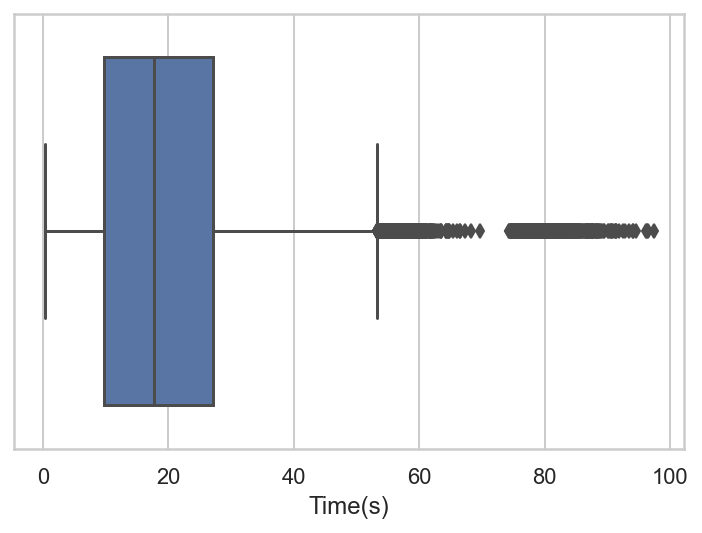

In [32]:
time_limit=2*60
calculateStarChart(algs,"1",time_limit,"Dataset 1",onlyResult=True,fileName="plots/dataset1_star.svg")

---
# Dataset 2

## Best config for GeneticNDS elitism

In [22]:
algs2=[]

configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="2")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitism',"2",20,200,"tournament",2,"onepoint",0.9,"flip1bit",0.7)
algs2.append(alg)
display(alg.findConfigurationData(df_alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
162,GeneticNDSAlgorithm,20.0,300.0,tournament,2.0,onepoint,0.90,flipeachbit,0.05,78.886002,0.135538,0.669718,0.001206,0.001336,142.2,33.5,0.128237
160,GeneticNDSAlgorithm,20.0,300.0,tournament,2.0,onepoint,0.90,flip1bit,1.00,109.009388,0.162444,0.629310,0.001199,0.001281,187.0,46.4,0.124757
88,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.85,flip1bit,0.50,67.214237,0.125090,0.634508,0.001197,0.001340,91.5,44.8,0.125220
396,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.60,flip1bit,0.50,91.700061,0.170290,0.608403,0.001197,0.001370,94.9,51.0,0.152361
144,GeneticNDSAlgorithm,20.0,300.0,tournament,2.0,onepoint,0.85,flip1bit,0.50,108.800019,0.147453,0.645492,0.001197,0.001300,172.4,46.3,0.124593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.85,flipeachbit,0.50,28.725213,0.158800,0.638820,0.001115,0.001249,61.8,32.7,0.152723
27,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.80,flipeachbit,1.00,30.477000,0.136989,0.652256,0.001114,0.001225,62.8,34.0,0.112114
53,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.90,flipeachbit,0.50,33.710366,0.142168,0.643737,0.001113,0.001218,58.7,44.4,0.120037
7,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.60,flipeachbit,0.00,29.170615,0.169232,0.669748,0.001102,0.001223,56.3,39.1,0.108186


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
1760,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001242,195.0,0.132868,0.694095,39.0,0.102175,216,NaN,NaN,<NA>
1761,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001287,210.0,0.124762,0.716996,41.0,0.111763,231,NaN,NaN,<NA>
1762,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001287,77.0,0.169543,0.668736,36.0,0.118310,200,NaN,NaN,<NA>
1763,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,115.0,0.198350,0.776206,39.0,0.118463,200,NaN,NaN,<NA>
1764,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,35.0,0.198350,0.677976,42.0,0.124977,200,NaN,NaN,<NA>
1765,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,112.0,0.198350,0.637625,45.0,0.128837,200,NaN,NaN,<NA>
1766,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,155.0,0.196491,0.599564,47.0,0.134393,200,NaN,NaN,<NA>
1767,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,16.0,0.196491,0.615266,47.0,0.131697,200,NaN,NaN,<NA>
1768,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,29.0,0.196491,0.614910,48.0,0.132212,200,NaN,NaN,<NA>
1769,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,149.0,0.198201,0.623768,48.0,0.136628,200,NaN,NaN,<NA>


## Best config for GeneticNDS elitismNDS

In [23]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="2")&(df_alg["Replacement Scheme"]=="elitismnds")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitismnds',"2",20,100,"tournament",2,"onepoint",0.6,"flip1bit",0.7)
algs2.append(alg)
display(alg.findConfigurationData(df_alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
394,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.6,flip1bit,0.1,114.379491,0.233963,0.636685,0.001430,0.002122,157.2,58.1,0.200122
59,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.6,flip1bit,0.2,81.448359,0.172532,0.621006,0.001423,0.001868,139.8,53.3,0.180079
395,GeneticNDSAlgorithm,40.0,200.0,tournament,2.0,onepoint,0.6,flip1bit,0.2,110.563131,0.207173,0.654127,0.001396,0.001977,149.6,54.2,0.200866
226,GeneticNDSAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flip1bit,0.1,104.136151,0.230205,0.626703,0.001381,0.002000,113.3,63.8,0.217436
339,GeneticNDSAlgorithm,40.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.2,61.363933,0.196202,0.658248,0.001369,0.001830,56.9,55.7,0.201742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flipeachbit,0.7,22.372298,0.121575,0.699605,0.001050,0.001106,55.0,24.6,0.116004
68,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.7,47.417161,0.151953,0.696796,0.001049,0.001118,84.1,29.2,0.116303
123,GeneticNDSAlgorithm,20.0,300.0,tournament,2.0,onepoint,0.6,flipeachbit,0.5,72.456443,0.168925,0.670348,0.001048,0.001111,152.7,29.0,0.104440
125,GeneticNDSAlgorithm,20.0,300.0,tournament,2.0,onepoint,0.6,flipeachbit,1.0,70.927481,0.150917,0.671564,0.001048,0.001112,149.9,30.3,0.123352


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
11130,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001390,121.0,0.077292,0.645754,31.0,0.107107,142,NaN,NaN,<NA>
11131,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001428,87.0,0.081031,0.673794,28.0,0.125453,108,NaN,NaN,<NA>
11132,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001413,60.0,0.113443,0.718055,28.0,0.134587,100,NaN,NaN,<NA>
11133,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001442,8.0,0.113443,0.639001,29.0,0.131440,100,NaN,NaN,<NA>
11134,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001486,73.0,0.107233,0.599848,31.0,0.126180,100,NaN,NaN,<NA>
11135,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001449,10.0,0.119966,0.597823,33.0,0.133830,100,NaN,NaN,<NA>
11136,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001397,76.0,0.094120,0.692590,30.0,0.130371,100,NaN,NaN,<NA>
11137,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001584,99.0,0.115928,0.694386,30.0,0.135691,120,NaN,NaN,<NA>
11138,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001491,15.0,0.144186,0.649922,32.0,0.140945,100,NaN,NaN,<NA>
11139,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001552,28.0,0.141548,0.660866,37.0,0.160879,100,NaN,NaN,<NA>


## Best config for NSGA-II elitism

In [24]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="NSGAIIAlgorithm")&(df_alg["Dataset"]=="2")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmDataGenetic("NSGAIIAlgorithm",'elitism',"2",30,200,"tournament",2,"onepoint",0.6,"flipeachbit",0.05)
algs2.append(alg)
display(alg.findConfigurationData(df_alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
176,NSGAIIAlgorithm,30.0,100.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,76.526687,0.336185,0.912455,0.001318,0.001690,101.8,30.0,0.226250
121,NSGAIIAlgorithm,20.0,300.0,tournament,2.0,onepoint,0.6,flipeachbit,0.10,97.213939,0.314445,0.878924,0.001274,0.001625,243.4,20.0,0.213810
120,NSGAIIAlgorithm,20.0,300.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,99.635788,0.472514,0.874870,0.001264,0.001695,206.4,20.0,0.272840
345,NSGAIIAlgorithm,40.0,100.0,tournament,2.0,onepoint,0.6,flipeachbit,0.10,105.338362,0.264359,0.930078,0.001257,0.001507,83.7,40.0,0.190449
177,NSGAIIAlgorithm,30.0,100.0,tournament,2.0,onepoint,0.6,flipeachbit,0.10,71.754679,0.255042,0.912119,0.001257,0.001497,71.2,29.9,0.193687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,NSGAIIAlgorithm,20.0,300.0,tournament,2.0,onepoint,0.6,flip1bit,1.00,103.334588,0.860311,0.875365,0.001086,0.001592,206.0,20.0,0.356764
1,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.05,32.082257,0.121591,0.890217,0.001085,0.001189,48.8,16.2,0.136592
7,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flipeachbit,0.00,35.644920,0.105943,0.894056,0.001085,0.001187,55.8,15.1,0.125672
0,NSGAIIAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.00,32.183212,0.114945,0.892376,0.001080,0.001181,39.7,14.7,0.134790


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
7210,2,NSGAIIAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,...,0.001774,174.0,0.492392,0.913921,30.0,0.273945,200,NaN,NaN,<NA>
7211,2,NSGAIIAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,...,0.001809,162.0,0.387462,0.911157,30.0,0.226570,200,NaN,NaN,<NA>
7212,2,NSGAIIAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,...,0.001734,188.0,0.399103,0.915438,30.0,0.264478,209,NaN,NaN,<NA>
7213,2,NSGAIIAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,...,0.001665,142.0,0.389701,0.914078,30.0,0.253621,200,NaN,NaN,<NA>
7214,2,NSGAIIAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,...,0.001796,168.0,0.424791,0.911854,30.0,0.236367,200,NaN,NaN,<NA>
7215,2,NSGAIIAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,...,0.002116,210.0,0.446080,0.911133,30.0,0.287808,231,NaN,NaN,<NA>
7216,2,NSGAIIAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,...,0.001810,169.0,0.537832,0.906638,30.0,0.277068,200,NaN,NaN,<NA>
7217,2,NSGAIIAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,...,0.001907,213.0,0.406400,0.911781,30.0,0.248542,234,NaN,NaN,<NA>
7218,2,NSGAIIAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,...,0.001847,157.0,0.426414,0.909341,30.0,0.239195,200,NaN,NaN,<NA>
7219,2,NSGAIIAlgorithm,30.0,200.0,tournament,2.0,onepoint,0.6,flipeachbit,0.05,...,0.001854,182.0,0.459364,0.908109,30.0,0.228571,203,NaN,NaN,<NA>


## Best config for GRASP

In [25]:
configs=["Algorithm","Iterations","Solutions per Iteration"]

df_a = df_alg[(df_alg["Algorithm"]=="GRASP")&(df_alg["Dataset"]=="2")&(df_alg["Local Search Type"]=="best_first_neighbor")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","NumSolutions","Spacing","NumGenerations"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmDataGrasp("GRASP","2",300,100,"best_first_neighbor")
algs2.append(alg)
display(alg.findConfigurationData(df_alg))

,Algorithm,Iterations,Solutions per Iteration,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_numsolutions,mean_spacing
24,GRASP,300.0,100.0,89.238793,0.093278,0.607190,0.003266,0.006869,585.0,0.339782
7,GRASP,50.0,60.0,9.865235,0.093278,0.584662,0.003265,0.006869,373.1,0.339986
23,GRASP,300.0,80.0,80.327606,0.093278,0.606701,0.003264,0.006869,565.1,0.339470
4,GRASP,20.0,100.0,6.688462,0.093278,0.577568,0.003263,0.006869,341.7,0.339539
6,GRASP,50.0,40.0,6.816064,0.093278,0.577568,0.003263,0.006869,341.7,0.339539
10,GRASP,100.0,20.0,6.868826,0.093278,0.577568,0.003263,0.006869,341.7,0.339539
19,GRASP,200.0,100.0,62.791504,0.093278,0.606025,0.003262,0.006869,548.3,0.339111
3,GRASP,20.0,80.0,5.245477,0.093278,0.575060,0.003262,0.006869,323.2,0.339680
14,GRASP,100.0,100.0,33.554508,0.093278,0.598141,0.003261,0.006869,477.9,0.339346
21,GRASP,300.0,40.0,38.626716,0.093278,0.600353,0.003260,0.006869,495.3,0.339327


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
180,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.093278,0.594088,437.0,0.337608,300,300.0,100.0,best_first_neighbor
181,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.093278,0.613655,496.0,0.339588,300,300.0,100.0,best_first_neighbor
182,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.093278,0.595057,536.0,0.338732,300,300.0,100.0,best_first_neighbor
183,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.093278,0.606535,577.0,0.337840,300,300.0,100.0,best_first_neighbor
184,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.093278,0.617809,616.0,0.340018,300,300.0,100.0,best_first_neighbor
185,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.093278,0.609526,611.0,0.341767,300,300.0,100.0,best_first_neighbor
186,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.093278,0.608088,630.0,0.342298,300,300.0,100.0,best_first_neighbor
187,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.093278,0.610317,634.0,0.340973,300,300.0,100.0,best_first_neighbor
188,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.093278,0.611017,655.0,0.339240,300,300.0,100.0,best_first_neighbor
189,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.093278,0.605808,658.0,0.339757,300,300.0,100.0,best_first_neighbor


## Generate Star Chart

,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
1760,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001242,195.0,0.080417,0.367355,0.041796,0.089649,216,NaN,NaN,<NA>
1761,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001287,210.0,0.070959,0.322478,0.044892,0.117551,231,NaN,NaN,<NA>
1762,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001287,77.0,0.123208,0.420636,0.037152,0.136604,200,NaN,NaN,<NA>
1763,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,115.0,0.156818,0.218721,0.041796,0.137050,200,NaN,NaN,<NA>
1764,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,35.0,0.156818,0.400761,0.046440,0.156004,200,NaN,NaN,<NA>
1765,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,112.0,0.156818,0.491789,0.051084,0.167240,200,NaN,NaN,<NA>
1766,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,155.0,0.154650,0.588883,0.054180,0.183407,200,NaN,NaN,<NA>
1767,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,16.0,0.154650,0.547374,0.054180,0.175562,200,NaN,NaN,<NA>
1768,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,29.0,0.154650,0.548289,0.055728,0.177061,200,NaN,NaN,<NA>
1769,2,GeneticNDSAlgorithm,20.0,200.0,tournament,2.0,onepoint,0.9,flip1bit,0.7,...,0.001334,149.0,0.156645,0.525768,0.055728,0.189910,200,NaN,NaN,<NA>


[0.07847081055196768, 0.4432053562437875, 0.15300393746360108, 0.04829721362229102, 0.1365634352965049, 0.07847081055196768]


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
11130,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001390,121.0,0.015573,0.472538,0.029412,0.104000,142,NaN,NaN,<NA>
11131,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001428,87.0,0.019936,0.409688,0.024768,0.157390,108,NaN,NaN,<NA>
11132,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001413,60.0,0.057753,0.320471,0.024768,0.183973,100,NaN,NaN,<NA>
11133,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001442,8.0,0.057753,0.488497,0.026316,0.174814,100,NaN,NaN,<NA>
11134,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001486,73.0,0.050508,0.588115,0.029412,0.159505,100,NaN,NaN,<NA>
11135,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001449,10.0,0.065363,0.593622,0.032508,0.181768,100,NaN,NaN,<NA>
11136,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001397,76.0,0.035207,0.370408,0.027864,0.171701,100,NaN,NaN,<NA>
11137,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001584,99.0,0.060652,0.366766,0.027864,0.187185,120,NaN,NaN,<NA>
11138,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001491,15.0,0.093622,0.462852,0.030960,0.202473,100,NaN,NaN,<NA>
11139,2,GeneticNDSAlgorithm,20.0,100.0,tournament,2.0,onepoint,0.6,flip1bit,0.7,...,0.001552,28.0,0.090545,0.438003,0.038700,0.260486,100,NaN,NaN,<NA>


[0.0920473412659715, 0.45109589298811237, 0.17832951683486606, 0.02925696594427245, 0.05469110643991284, 0.0920473412659715]


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type


[nan, nan, nan, nan, nan, nan]


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,...,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing,NumGenerations,Iterations,Solutions per Iteration,Local Search Type
180,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.034225,0.603876,0.657895,0.774792,300,300.0,100.0,best_first_neighbor
181,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.034225,0.551533,0.749226,0.780553,300,300.0,100.0,best_first_neighbor
182,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.034225,0.601203,0.811146,0.778062,300,300.0,100.0,best_first_neighbor
183,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.034225,0.570188,0.874613,0.775467,300,300.0,100.0,best_first_neighbor
184,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.034225,0.540847,0.934985,0.781805,300,300.0,100.0,best_first_neighbor
185,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.034225,0.562300,0.927245,0.786896,300,300.0,100.0,best_first_neighbor
186,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.034225,0.566083,0.956656,0.788439,300,300.0,100.0,best_first_neighbor
187,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.034225,0.560226,0.962848,0.784586,300,300.0,100.0,best_first_neighbor
188,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.034225,0.558395,0.995356,0.779542,300,300.0,100.0,best_first_neighbor
189,2,GRASP,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,...,0.006869,NaN,0.034225,0.572120,1.000000,0.781046,300,300.0,100.0,best_first_neighbor


[0.9780558741554204, 0.5686772334038326, 0.7811187889992139, 0.8869969040247678, 0.03422471845989972, 0.9780558741554204]


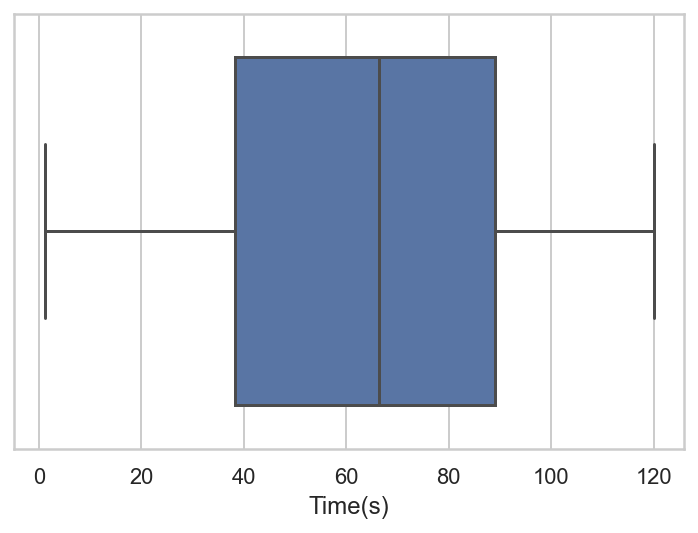

In [33]:
calculateStarChart(algs2,"2",time_limit,"Dataset 2",onlyResult=True,fileName="plots/dataset2_star.svg")

## Wilcoxon Test

In [ ]:
cols=["AvgValue","HV","Spread","Spacing","NumSolutions","BestGeneration","Time(s)"]
maxmin=[1,1,-1,1,1,1,-1]

for j in range(len(cols)): 
    print(cols[j])
    results=list()
    best_avg=0
    best_avgn=10**9
    best_alg_index=None
    for i in range(len(algs2)):
        avg=np.mean((findConfigurationData(df_alg,algs2[i])[cols])[cols[j]].values)
        results.append("{:.3f}".format(avg))
        if maxmin[j]>0 and avg>best_avg:
            best_avg=avg
            best_alg_index=i
        elif maxmin[j]<0 and avg<best_avgn:
            best_avgn=avg
            best_alg_index=i

    p_best=True
    p_list=[]
    for i in range(len(algs2)):
        if i!=best_alg_index:
            dataA=(findConfigurationData(df_alg,algs2[best_alg_index])[cols])[cols[j]].values
            dataB=(findConfigurationData(df_alg,algs2[i])[cols])[cols[j]].values
            _, p = ranksums(dataA, dataB)
            print("p:",p)
            if p>=0.05:
                #print(dataA)
                #print(dataB)
                p_best=False
            else:
                p_list.append(i)

    if p_best:
        mark = '*'
    else:
        mark = ''
    for index in p_list:
        results[index]=results[index]+'-'
    #results[best_alg_index]=results[best_alg_index]+mark
    results.insert(0,cols[j])
    print(results)
    

## Generate Dataset 1 Pareto comparison

Running...
Time:  46.79593110084534
AvgValue:  0.024240413507992654
NumSolutions:  35
HV:  1.0
Spread:  0.9281847805104517
Spacing:  0.43893397187667793
Time:  7.910693407058716
AvgValue:  0.018008084093037866
NumSolutions:  26
HV:  0.5425202555826361
Spread:  0.7777969880851401
Spacing:  0.2589225225761046

NDS created has 35 solution(s)


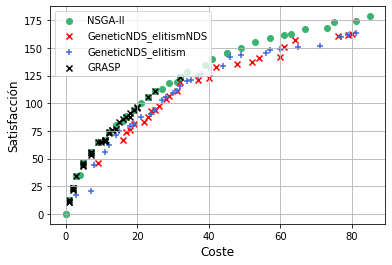

<Figure size 432x288 with 0 Axes>

In [6]:
from algorithms.genetic.genetic_algorithm import GeneticAlgorithm
from algorithms.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.GRASP.GRASP import GRASP
from datasets.dataset1 import generate_dataset1_genes
from algorithms.genetic_nds.genetic_nds_algorithm import GeneticNDSAlgorithm
from datasets.dataset2 import generate_dataset2_genes
from models.problem import Problem
import matplotlib.pyplot as plt
import pandas as pd
# generar los genes de los requisitos------------------------------------------------------------------
genes=generate_dataset1_genes()
objectives_minimization=["MAX","MIN"]

# instanciar el problema------------------------------------------------------------------
problem=Problem(genes,objectives_minimization)

# crear seed random------------------------------------------------------------------
seed=54

# iniciar------------------------------------------------------------------
print("Running...")

algorithm=NSGAIIAlgorithm(problem,random_seed=seed,population_length=40,max_generations=300,crossover_prob=0.85,
						   crossover="onepoint",mutation_prob=1,mutation="flip1bit",replacement="elitism")

result=algorithm.run()
print("Time: ",result["time"])
print("AvgValue: ",result["avgValue"])
if "numSolutions" in result:
	print("NumSolutions: ",result["numSolutions"])
	print("HV: ",result["hv"])
	print("Spread: ",result["spread"])
	print("Spacing: ",result["spacing"])

func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]

algorithm=GeneticNDSAlgorithm(problem,random_seed=seed,population_length=30,max_generations=200,crossover_prob=0.9,
							 crossover="onepoint", mutation_prob=0.1,mutation="flip1bit",replacement="elitismnds")
result=algorithm.run()
print("Time: ",result["time"])
print("AvgValue: ",result["avgValue"])
if "numSolutions" in result:
	print("NumSolutions: ",result["numSolutions"])
	print("HV: ",result["hv"])
	print("Spread: ",result["spread"])
	print("Spacing: ",result["spacing"])
func = [i.objectives for i in result["population"]]
function3 = [i[0].value for i in func]
function4 = [i[1].value for i in func]


algorithm=GeneticNDSAlgorithm(problem,random_seed=seed,population_length=40,max_generations=200,crossover_prob=0.85,
							  crossover="onepoint", mutation_prob=0.1,mutation="flip1bit",replacement="elitism")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function5 = [i[0].value for i in func]
function6 = [i[1].value for i in func]

algorithm=GRASP(dataset=1,iterations=20,solutions_per_iteration=20,local_search_type="best_first_neighbor")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function7 = [i[0].value for i in func]
function8 = [i[1].value for i in func]

plt.xlabel('Coste', fontsize=12)
plt.ylabel('Satisfacción', fontsize=12)
plt.scatter(function2, function1, marker='o',label="NSGA-II",c="#3cb371")
plt.scatter(function4, function3, marker='x',label="GeneticNDS_elitismNDS",c="#ff0000")
plt.scatter(function6, function5, marker='+',label="GeneticNDS_elitism",c="#4169e1")
plt.scatter(function8, function7, marker='x',label="GRASP",c="#000000")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.grid(True)
plt.show()
plt.draw()
fig1.savefig('plots/dataset1_pareto.svg', dpi=100)

## Generate Dataset 2 Pareto comparison

Running...
Time:  106.06595993041992
AvgValue:  0.0013491975624210812
NumSolutions:  30
HV:  0.4507271123417695
Spread:  0.9081744877106198
Spacing:  0.23661919844747256
Time:  23.060410737991333
AvgValue:  0.0011507038163394757
NumSolutions:  37
HV:  0.11940722333199612
Spread:  0.5835242536931379
Spacing:  0.10599376455783177

NDS created has 418 solution(s)


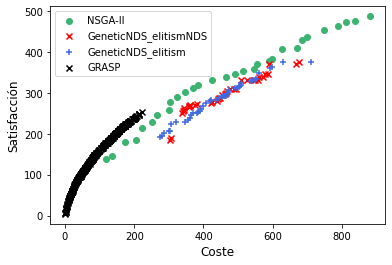

<Figure size 432x288 with 0 Axes>

In [7]:
from algorithms.genetic.genetic_algorithm import GeneticAlgorithm
from algorithms.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.genetic_nds.genetic_nds_algorithm import GeneticNDSAlgorithm
from algorithms.GRASP.GRASP import GRASP
from datasets.dataset2 import generate_dataset2_genes
from models.problem import Problem
import matplotlib.pyplot as plt
import pandas as pd
# generar los genes de los requisitos------------------------------------------------------------------
genes=generate_dataset2_genes()
objectives_minimization=["MAX","MIN"]

# instanciar el problema------------------------------------------------------------------
problem=Problem(genes,objectives_minimization)

# crear seed random------------------------------------------------------------------
seed=54

# iniciar------------------------------------------------------------------
print("Running...")

algorithm=NSGAIIAlgorithm(problem,random_seed=seed,population_length=30,max_generations=200,crossover_prob=0.6,
						   crossover="onepoint",mutation_prob=0.05,mutation="flipeachbit",replacement="elitism")

result=algorithm.run()
print("Time: ",result["time"])
print("AvgValue: ",result["avgValue"])
if "numSolutions" in result:
	print("NumSolutions: ",result["numSolutions"])
	print("HV: ",result["hv"])
	print("Spread: ",result["spread"])
	print("Spacing: ",result["spacing"])

func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]

algorithm=GeneticNDSAlgorithm(problem,random_seed=seed,population_length=20,max_generations=100,crossover_prob=0.6,
							 crossover="onepoint", mutation_prob=0.7,mutation="flip1bit",replacement="elitismnds")
result=algorithm.run()
print("Time: ",result["time"])
print("AvgValue: ",result["avgValue"])
if "numSolutions" in result:
	print("NumSolutions: ",result["numSolutions"])
	print("HV: ",result["hv"])
	print("Spread: ",result["spread"])
	print("Spacing: ",result["spacing"])
func = [i.objectives for i in result["population"]]
function3 = [i[0].value for i in func]
function4 = [i[1].value for i in func]


algorithm=GeneticNDSAlgorithm(problem,random_seed=seed,population_length=20,max_generations=200,crossover_prob=0.9,
							  crossover="onepoint", mutation_prob=0.7,mutation="flip1bit",replacement="elitism")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function5 = [i[0].value for i in func]
function6 = [i[1].value for i in func]

algorithm=GRASP(dataset=2,iterations=300,solutions_per_iteration=100,local_search_type="best_first_neighbor")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function7 = [i[0].value for i in func]
function8 = [i[1].value for i in func]

plt.xlabel('Coste', fontsize=12)
plt.ylabel('Satisfacción', fontsize=12)
plt.scatter(function2, function1, marker='o',label="NSGA-II",c="#3cb371")
plt.scatter(function4, function3, marker='x',label="GeneticNDS_elitismNDS",c="#ff0000")
plt.scatter(function6, function5, marker='+',label="GeneticNDS_elitism",c="#4169e1")
plt.scatter(function8, function7, marker='x',label="GRASP",c="#000000")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('plots/dataset2_pareto.svg', dpi=100)

Running...

NDS created has 432 solution(s)
228.60000000000002 183
201.00000000000003 149
247.4 214
242.2 206
206.80000000000004 156
206.60000000000002 156
136.8 78
41.800000000000004 13
235.60000000000002 194
248.0 215
153.60000000000002 93
212.40000000000003 163
230.00000000000003 187
253.20000000000002 223
205.80000000000004 154
229.60000000000002 185
15.6 3
115.60000000000001 59
224.8 181
225.00000000000003 182
224.60000000000002 180
235.8 197
230.4 188
223.40000000000003 177
130.6 72
11.6 2
148.60000000000002 88
217.80000000000004 170
22.0 5
218.40000000000003 172
153.8 94
96.00000000000001 43
224.00000000000003 178
116.0 59
22.2 5
5.8 1
9.8 2
93.8 40
230.20000000000002 188
27.2 7
131.0 73
212.20000000000005 163
229.20000000000002 185
5.8 1
199.40000000000003 145
195.00000000000003 142
144.40000000000003 86
170.00000000000003 110
51.79999999999999 17
4.0 1
99.8 44
235.60000000000002 196
237.20000000000002 201
124.80000000000001 67
28.599999999999998 7
222.60000000000002 174
189.00

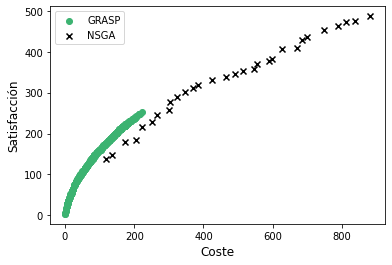

<Figure size 432x288 with 0 Axes>

In [9]:
from algorithms.genetic.genetic_algorithm import GeneticAlgorithm
from algorithms.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.genetic_nds.genetic_nds_algorithm import GeneticNDSAlgorithm
from algorithms.GRASP.GRASP import GRASP
from datasets.dataset1 import generate_dataset1_genes
from datasets.dataset2 import generate_dataset2_genes

from models.problem import Problem
import matplotlib.pyplot as plt
import pandas as pd
# crear seed random------------------------------------------------------------------
genes=generate_dataset2_genes()
objectives_minimization=["MAX","MIN"]

# instanciar el problema------------------------------------------------------------------
problem=Problem(genes,objectives_minimization)

# crear seed random------------------------------------------------------------------
seed=54

# iniciar------------------------------------------------------------------
print("Running...")

algorithm=GRASP(dataset=2,iterations=300,solutions_per_iteration=100,local_search_type="best_first_neighbor")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]

for i in func:
    print(i[0].value,i[1].value)
    
algorithm=NSGAIIAlgorithm(problem,random_seed=seed,population_length=30,max_generations=200,crossover_prob=0.6,
						   crossover="onepoint",mutation_prob=0.05,mutation="flipeachbit",replacement="elitism")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function3 = [i[0].value for i in func]
function4 = [i[1].value for i in func]

plt.xlabel('Coste', fontsize=12)
plt.ylabel('Satisfacción', fontsize=12)
plt.scatter(function2, function1, marker='o',label="GRASP",c="#3cb371")
plt.scatter(function4, function3, marker='x',label="NSGA",c="#000000")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.show()
plt.draw()
